# Import Packages

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from jcopml.time_series.decomposition import additive_decomposition, multiplicative_decomposition
from jcopml.time_series import auto_ets

from luwiji.time_series import illustration

In [7]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Import Data

In [19]:
df = pd.read_csv("DCA_data.csv",parse_dates=['Date'])
df.head()

,Well,Date,Oil_Calday,Oil_Cum
0,01-02,1987-12-01,432,13.38
1,01-02,1988-01-01,518,29.44
2,01-02,1988-02-01,452,42.56
3,01-02,1988-03-01,446,56.39
4,01-02,1988-04-01,450,69.87


In [20]:
def f(x):
    plt.figure(figsize=(8,6))
    plt.scatter(df[df['Well']==x]['Date'],df[df['Well']==x]['Oil_Calday'])
    plt.xlabel('Date')
    plt.ylabel('Oil CalDay (stb/d)')

interact(f, x=df['Well'].unique());

interactive(children=(Dropdown(description='x', options=('01-02', '01-10', '02-10', '03-10', '04-01', '04-11',…

In [21]:
x = input("Selected Well: ")
df_sel = df[df['Well']==x]

Selected Well: 09-02


# Impute Missing Values

In [23]:
df_sel.set_index('Date',drop=True,inplace=True)
df = df_sel[['Oil_Calday']]
df_new = pd.DataFrame(index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS'))
df = df_new.merge(df,how='left',left_index=True,right_index=True)
df[df['Oil_Calday'].isna()]

,Oil_Calday
1981-10-01,NaN
1981-11-01,NaN
1982-08-01,NaN
1982-09-01,NaN
1982-11-01,NaN
1982-12-01,NaN
1983-01-01,NaN
1983-02-01,NaN
1983-07-01,NaN
1983-08-01,NaN


In [24]:
df['Oil_Calday'] = df['Oil_Calday'].interpolate(method='time')
df[df['Oil_Calday'].isna()]

,Oil_Calday


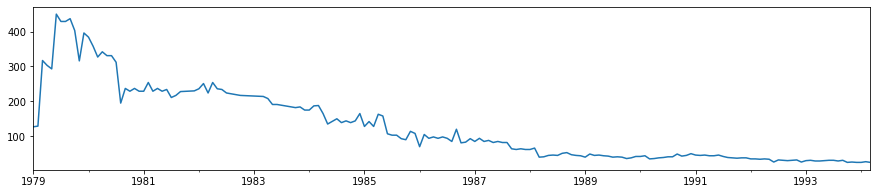

In [25]:
series = df['Oil_Calday']
series.plot(figsize=(15,3))

# Error-Trend-Seasonal (ETS) Smoothing Method

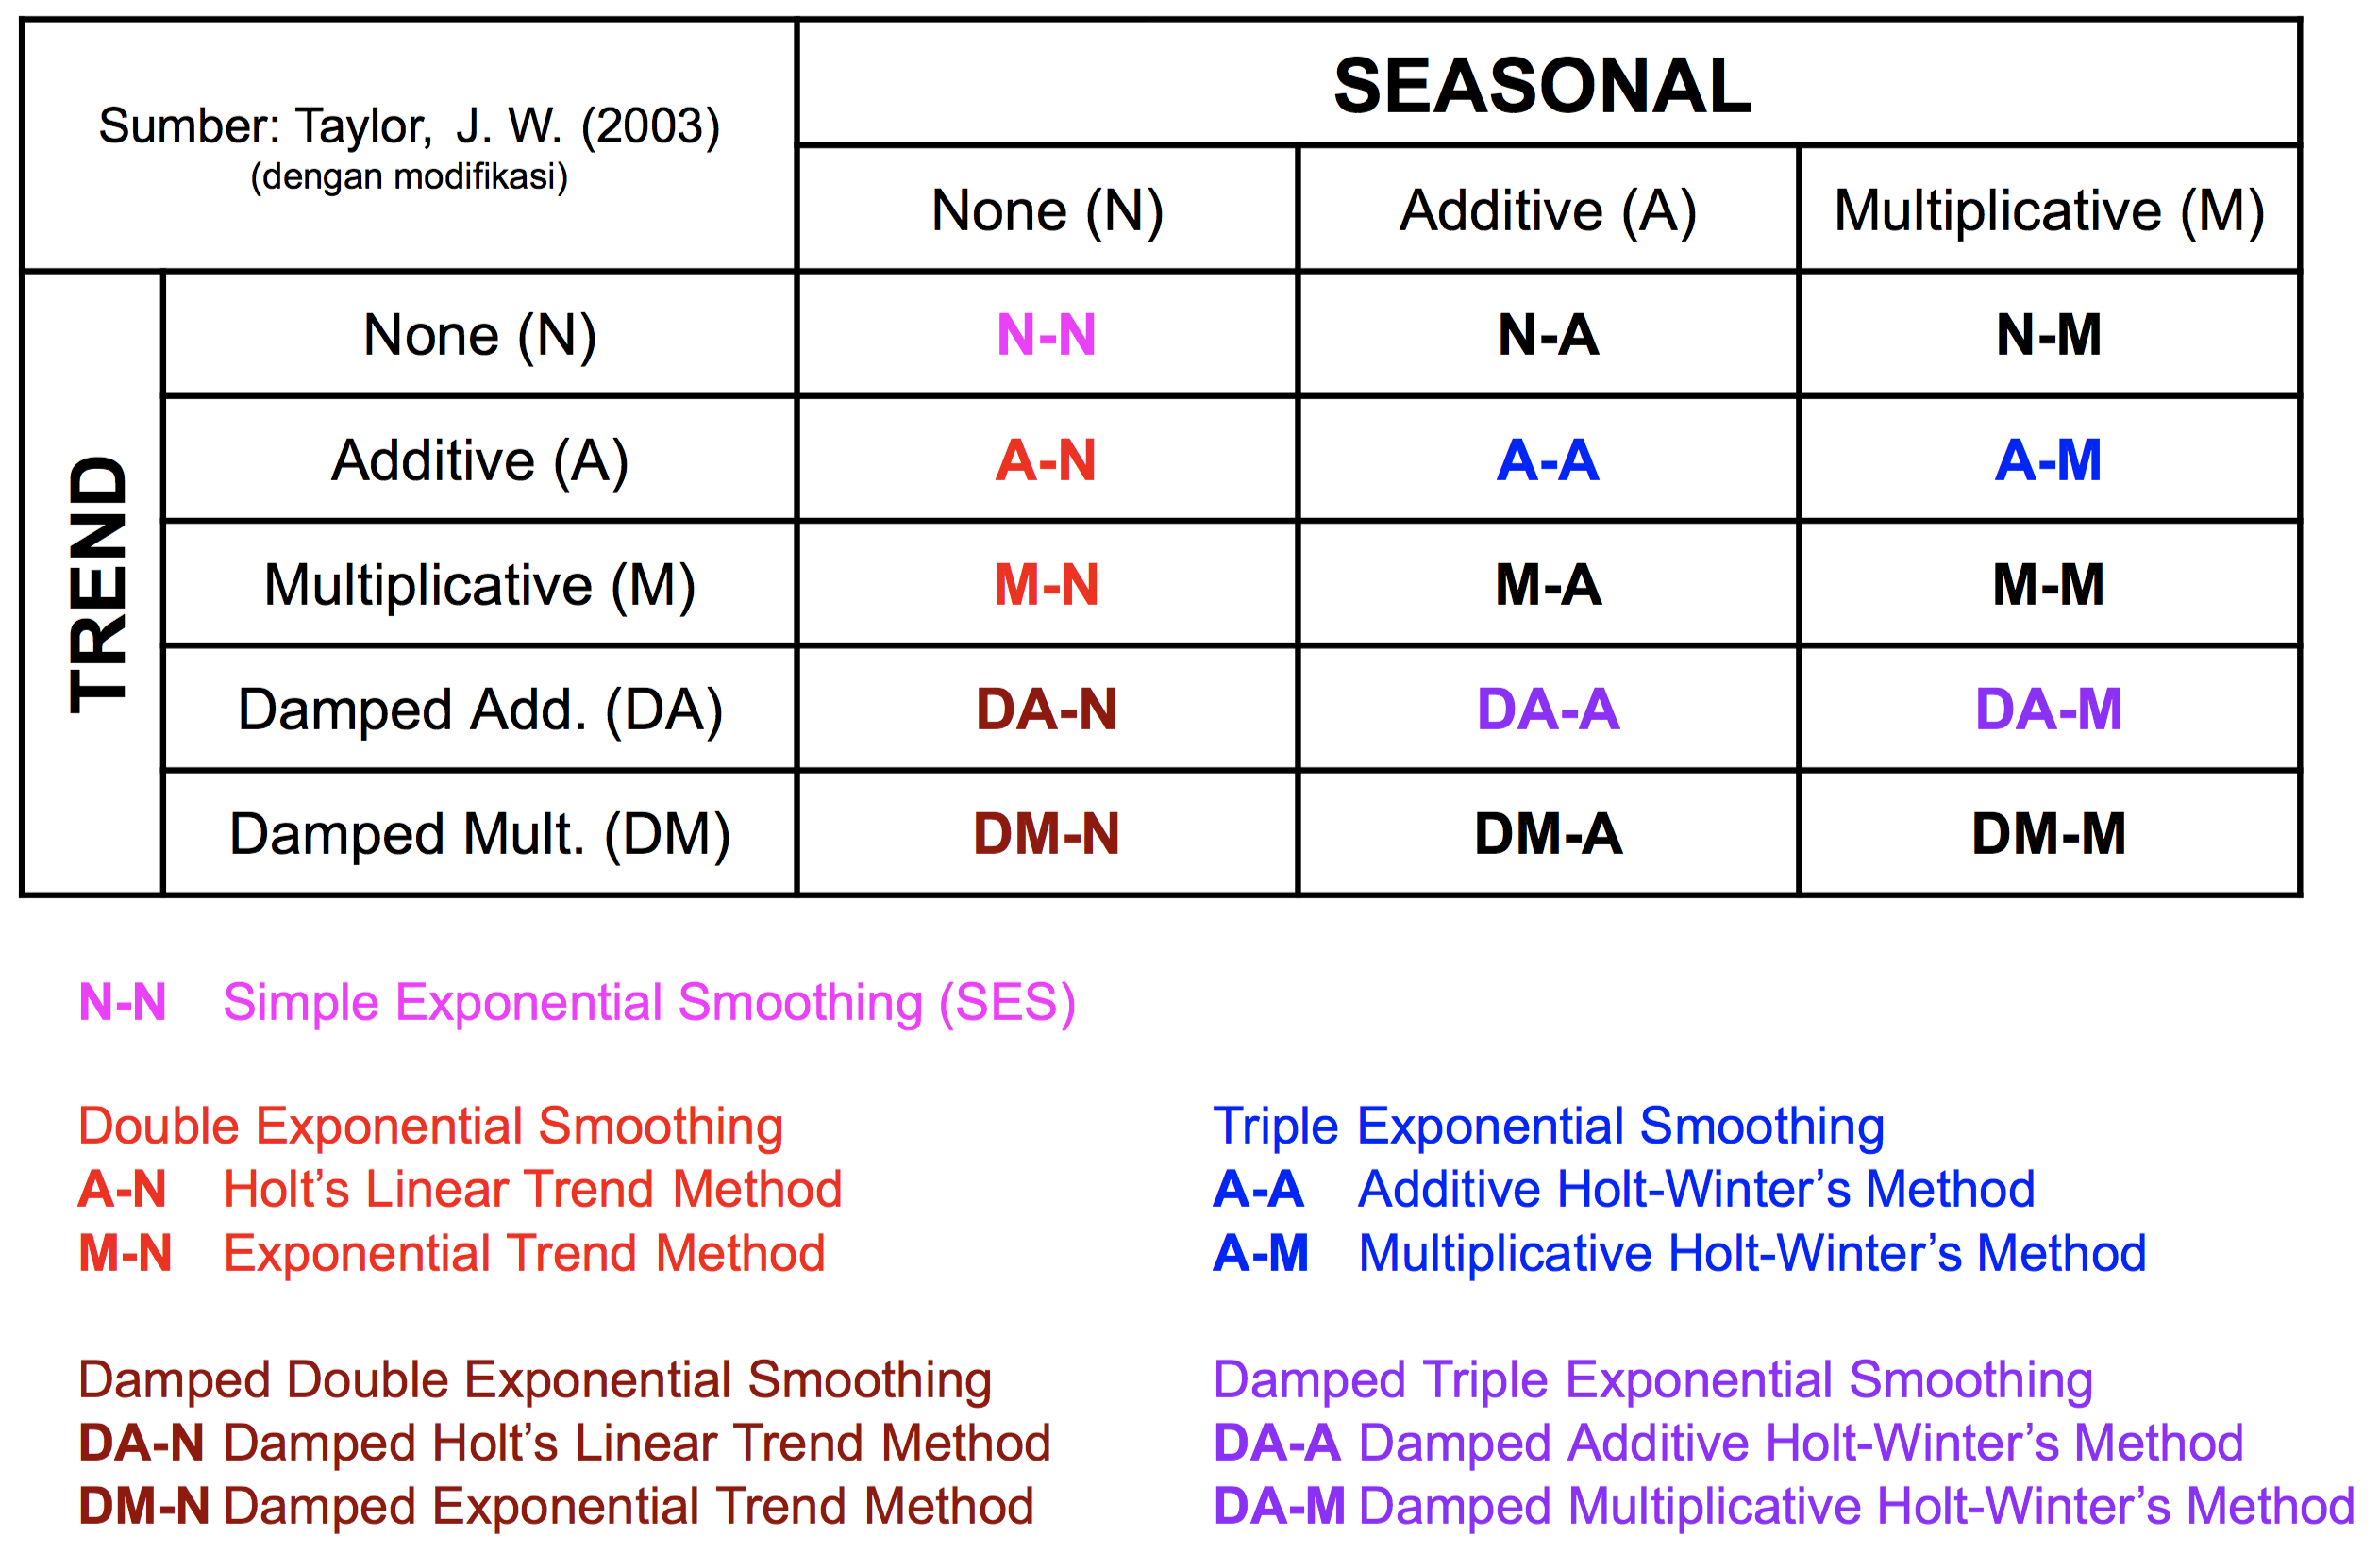

In [26]:
illustration.ets_model

## Additive Decomposition Check

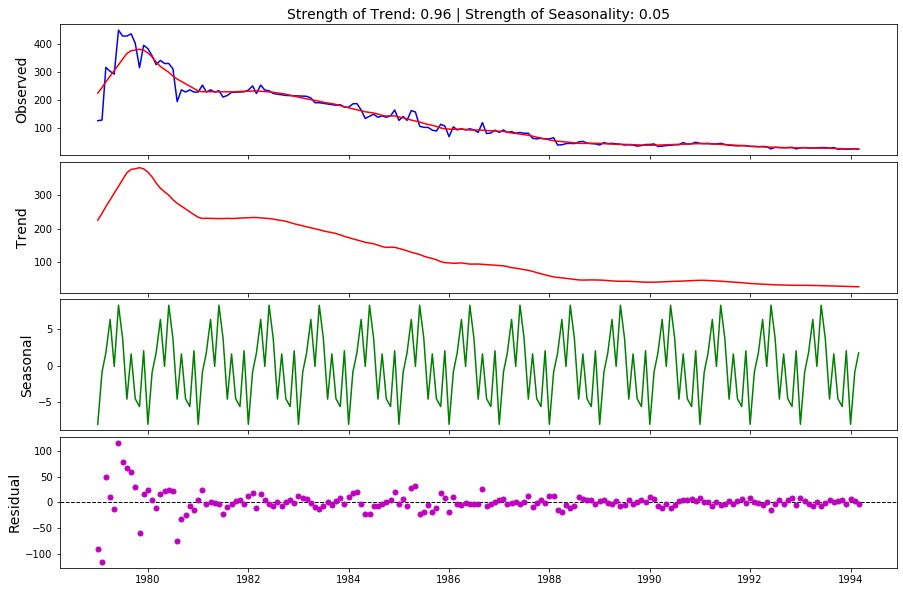

In [27]:
components = additive_decomposition(series, plot=True,extrapolate_trend=True)

## Multiplicative Decomposition Check

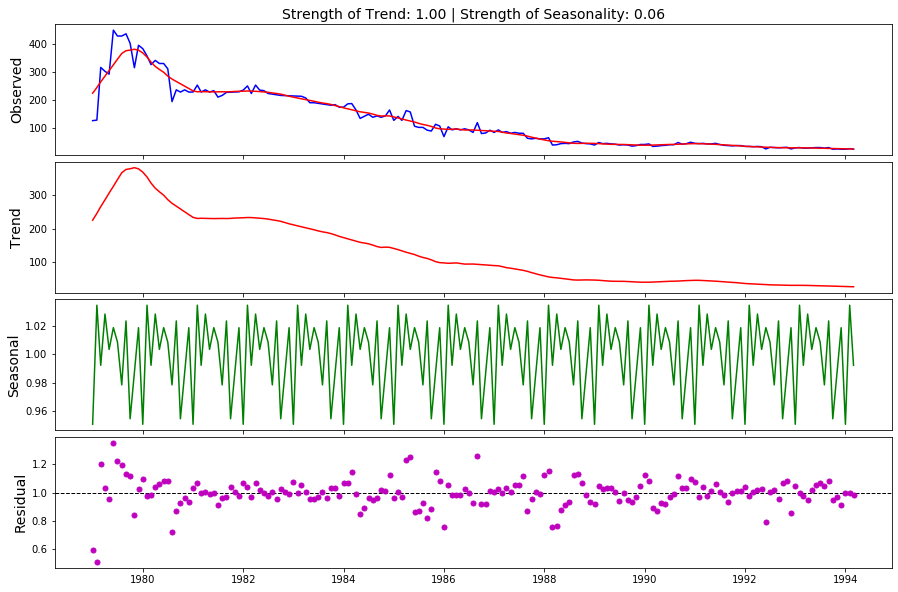

In [28]:
components = multiplicative_decomposition(series, plot=True,extrapolate_trend=True)

From our time-series data shape, it looks like we have multiplicative trend (The trend changes along the time), and a negligible seasonal. Let's try to predict with **Double Exponential Smoothing - Exponential Trend Method** First, then try `jcopml-ts` Auto ETS to determine the best model for our Decline Curve

## Double Exponential Smoothing - Exponential Trend Method

### Training

In [29]:
X_train, X_test = series[:-25], series[-25:]

In [30]:
es = ExponentialSmoothing(X_train,trend="mul",seasonal="mul")
model = es.fit(optimized=True, use_boxcox=True)

C:\Users\ANaufal\AppData\Local\Continuum\anaconda3\envs\jcop_ts\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\ANaufal\AppData\Local\Continuum\anaconda3\envs\jcop_ts\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


### Forecast

In [31]:
pred = model.predict(len(X_train)-10,len(X_train)+200)

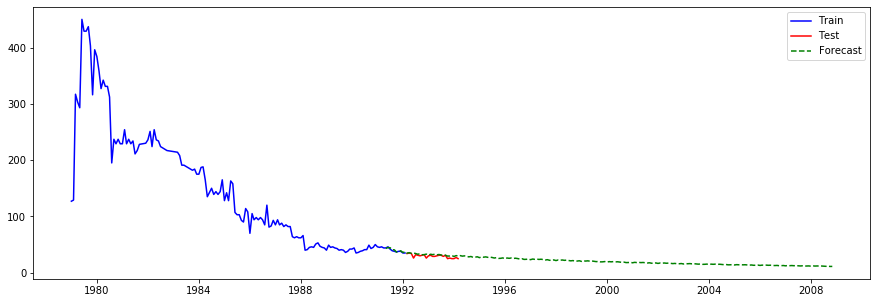

In [32]:
plt.figure(figsize=(15,5))
plt.plot(X_train,"b-", label="Train")
plt.plot(X_test,"r-", label="Test")
plt.plot(pred,"g--", label="Forecast")
plt.legend()

It looks pretty good, but let's try to use Grid Search optimizer to find the best model (trend? seasonal? damped or not? boxcox transformation?) for our Decline Curve

## Auto ETS

### Training

In [34]:
model, cv_results = auto_ets(X_train, scoring="mse")

### Results

In [35]:
cv_results.head()

,trend,seasonal,damped,boxcox,mse_0,mse_1,mse_2,mse_3,mean_mse
21,mul,None,False,False,349.914613,510.767699,596.900493,56.008125,378.397732
27,mul,mul,False,False,462.781713,1165.876750,197.721897,174.375502,500.188965
25,mul,mul,True,False,606.609327,1101.445658,196.815430,173.538031,519.602112
26,mul,mul,False,True,537.084564,1526.136885,895.214816,54.519689,753.238989
19,mul,None,True,False,1273.176916,1030.947843,1176.793716,19.364340,875.070704


The #1 result is "mul" trend (Not damped) with No seasonal and no boxcox transformation

### Forecast

In [36]:
pred = model.predict(len(X_train)-10,len(X_train)+200)

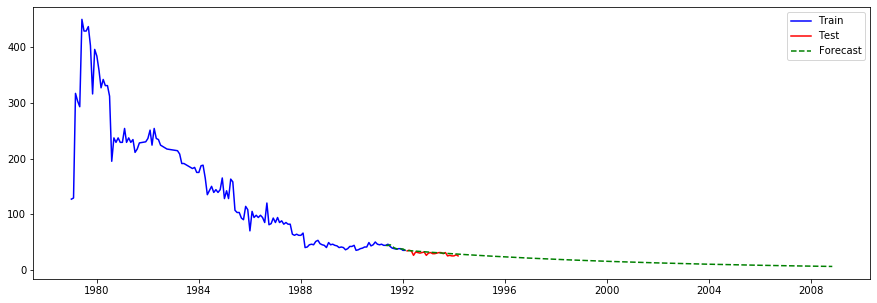

In [37]:
plt.figure(figsize=(15,5))
plt.plot(X_train,"b-", label="Train")
plt.plot(X_test,"r-", label="Test")
plt.plot(pred,"g--", label="Forecast")
plt.legend()